# Ship Detection- Project AIRBUS 2019
## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

Import:
And load files :

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage as Montage
from skimage.morphology import binary_opening, disk, label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
montage_rgb = lambda x: np.stack([Montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
warnings.filterwarnings("ignore")
ship_dir = 'D:\Projet Airbus/'
train_image_dir = os.path.join(ship_dir, 'Train')# Images for training
test_image_dir = os.path.join(ship_dir, 'Test')# Images for testing
masks = pd.read_csv(ship_dir + 'train_ship_segmentations_v2.csv') # Markers for ships

os.chdir("D:\Projet Airbus/Train")

Various functions needed to show the images.

In [6]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [7]:
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

## Make sure encode/decode works
Given the process

RLE0  ⟶  Image0  ⟶  RLE1  ⟶  Image1

   Decode  =>   Encode  =>    Decode   
We want to check if/that  Image0=?Image1  We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


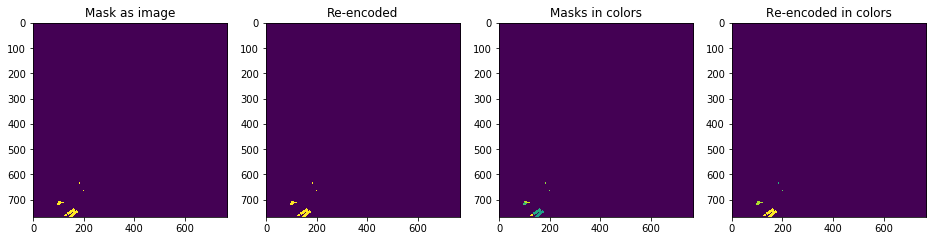

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

Function to plot some images and their Mask.

In [11]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    '''
    Function that checks if there is a ship in image
    '''
    df = masks[masks['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False
    
def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = masks[masks['ImageId'] == key].iloc[:,1]
    marks= np.zeros((768,768,1))
    if is_empty(key):
        return marks
    else:
        for i in range(len(df)):
            marks += mark_part(df.iloc[i])
        return np.transpose(marks, (1,0,2))

Randomly chosen images with corresponding masks


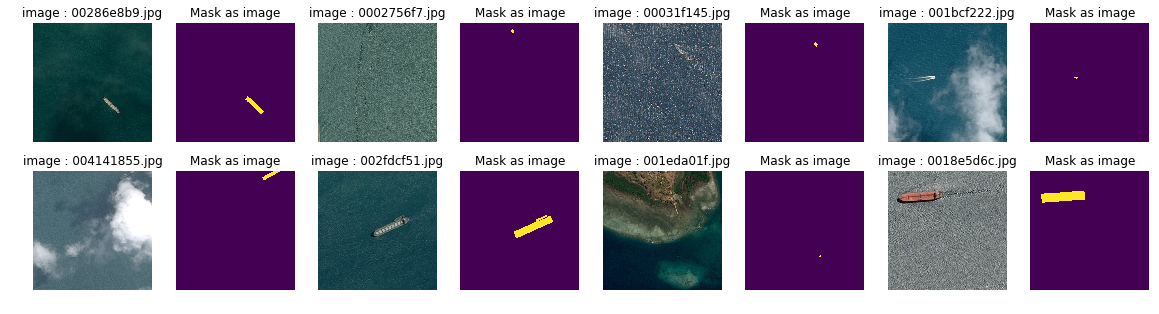

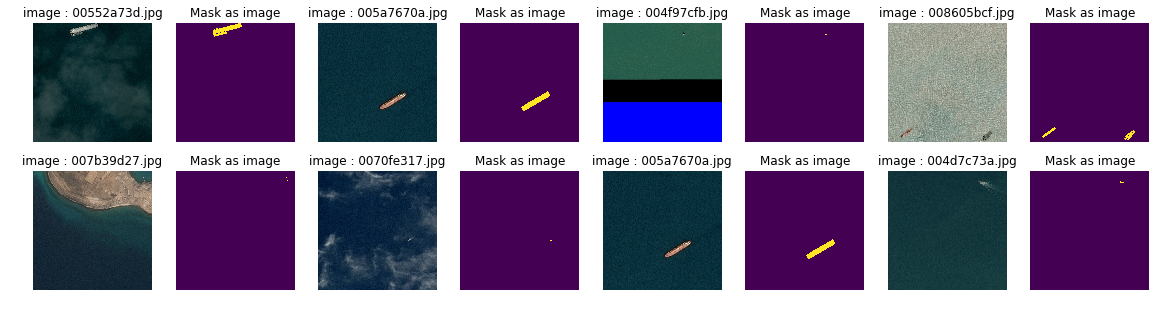

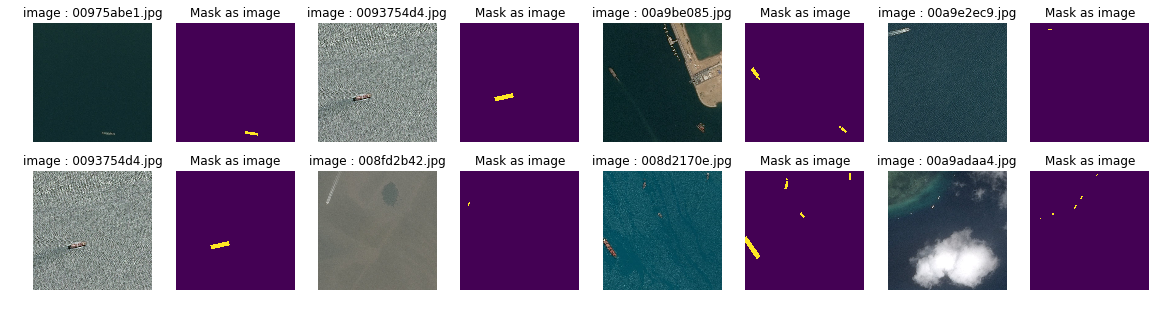

In [24]:
def draw(liste):
    l = int(len(liste)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(imread(liste[i]))
        plt.title('image : '+ liste[i])
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        rle_0 = masks.query('ImageId=="' + liste[i]+ '"')['EncodedPixels']
        img_0 = masks_as_image(rle_0)
        plt.imshow(img_0)
        plt.title('Mask as image')
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()
print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[:200] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[200:400] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[400:600] if not is_empty(i)], size = 8))

## Data Augmentation by rotation transformations 

In [25]:
def transform(X, Y):
    '''
    Function for augmenting images. 
    It takes original image and corresponding mask and performs the
    same flipping and rotation transforamtions on both in order to 
    perserve the overlapping of ships and their masks
    '''
# add noise:
    x = np.copy(X)
    y = np.copy(Y)
    x[:,:,0] = x[:,:,0] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,1] = x[:,:,1] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,2] = x[:,:,2] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    # Adding Gaussian noise on each rgb channel; this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x<0)] = 0
    x[np.where(x>1)] = 1
# axes swap:
    if np.random.rand()<0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
# vertical flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
# horizontal flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
    return x, y  

In [26]:
def plot_transformed(file):
    '''
    Plots specified Original image and five augmentations
    (five images created transforming original with function 'transform()')
    '''
    X, Y = plt.imread(file), masks_as_image(masks.query('ImageId=="' + file+ '"')['EncodedPixels'])
    plt.figure(figsize = (19,8))
    plt.subplot(253, title ='Original Image')
    X, Y = plt.imread(file)/255, masks_as_image(masks.query('ImageId=="' + file+ '"')['EncodedPixels'])
    plt.imshow(X)
    plt.axis('off')
    plt.subplot(256, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(257, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(258, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(259, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(2,5,10, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.suptitle(file,x=0.3, y=0.7, verticalalignment ='top', fontsize = 22)
    plt.show()

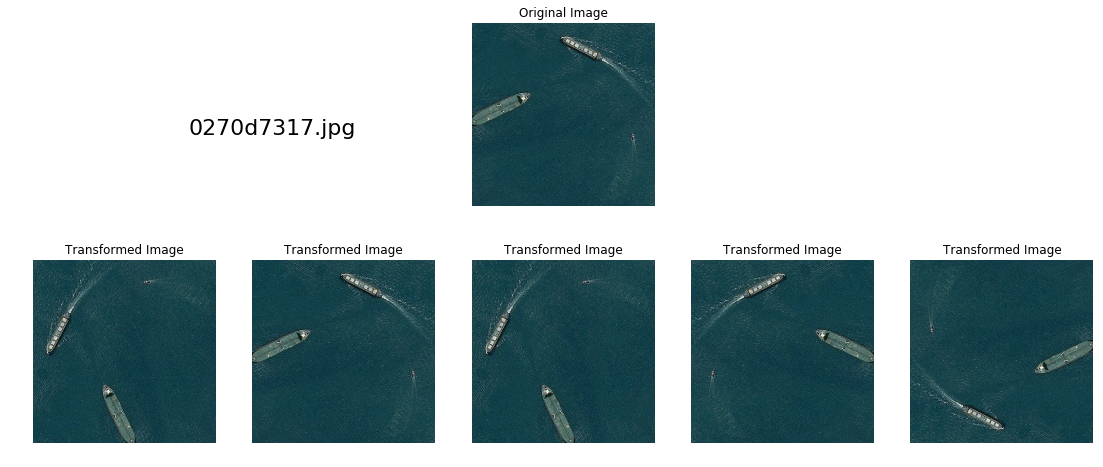

In [29]:
plot_transformed('0270d7317.jpg')

In [30]:
def make_batch(files, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 768, 768, 3))
    Y = np.zeros((batch_size, 768, 768, 1)) # I add 1 here to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship))/255.0 # Original images are in 0-255 range, I want it in 0-1
        Y[i]= Masks_all(ship)
    return X, Y

In [31]:
def Generator(files, batch_size):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = make_batch(files, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = transform(X[i], Y[i])
        yield X, Y

## Split into training and validation sets
We stratify by the number of boats appearing so we have nice balances in each set

ImageId  ships  has_ship has_ship_vec  file_size_kb
161319  d68f907eb.jpg      0       0.0        [0.0]    122.168945
182546  f2bf7980b.jpg      0       0.0        [0.0]    110.581055
164584  dafba99b3.jpg      1       1.0        [1.0]    143.382812
182643  f2e08ba52.jpg      1       1.0        [1.0]    102.428711
129177  abcf1eff0.jpg      0       0.0        [0.0]     66.894531
144812  c08e67622.jpg      0       0.0        [0.0]    126.078125
34942   2e7ae4c14.jpg      1       1.0        [1.0]    222.620117

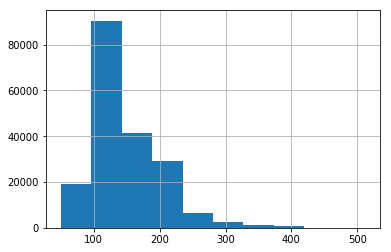

In [32]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join('D:\Projet Airbus/Train', 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

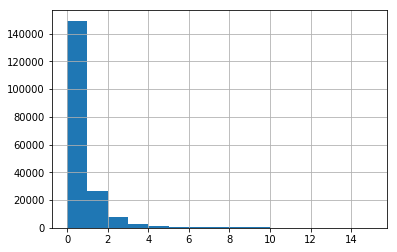

In [33]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

### Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

12788 masks


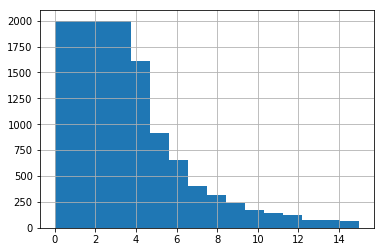

In [34]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [35]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, test_size = 0.2)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35301 training masks
8901 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [36]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


TypeError: 'module' object is not callable

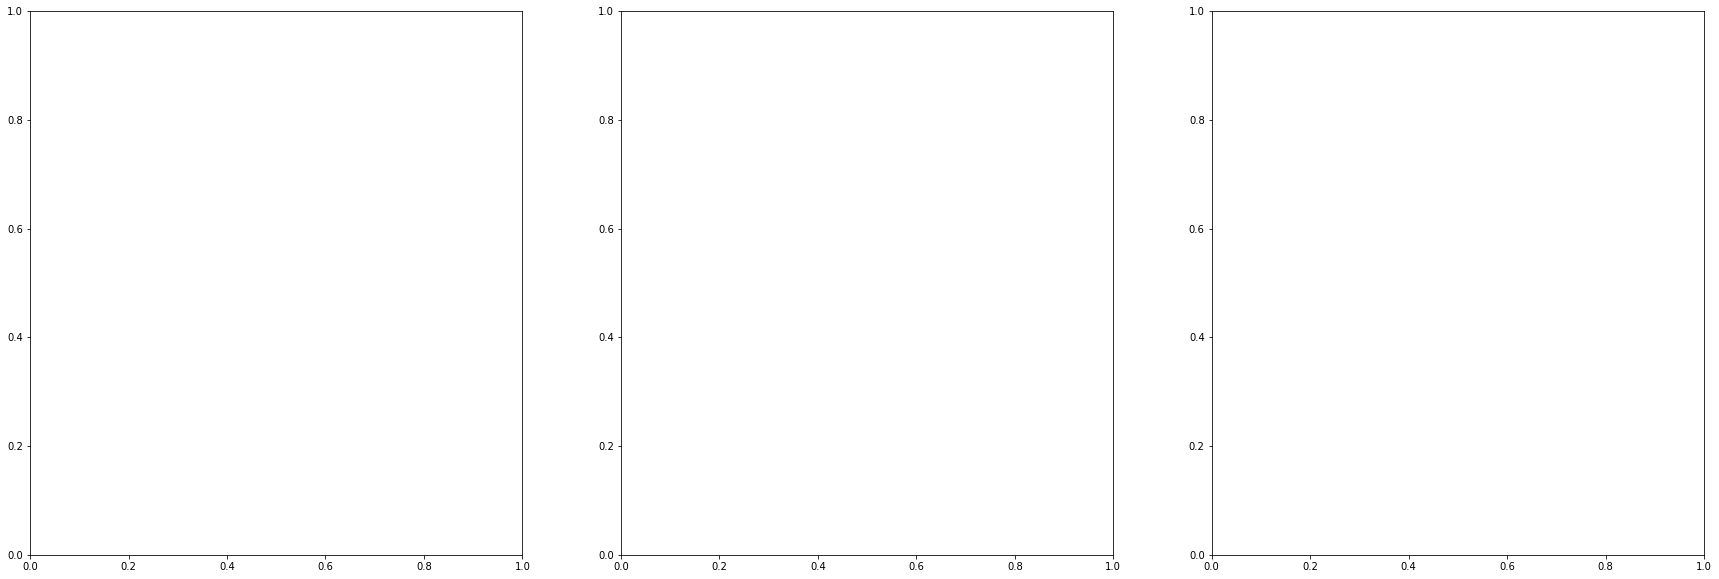

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = Montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Validation Set

In [38]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
Wall time: 18.3 s


# Data Augmentation by the module of Keras
(ImageDataGenerator from keras.processing)

In [39]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


TypeError: 'module' object is not callable

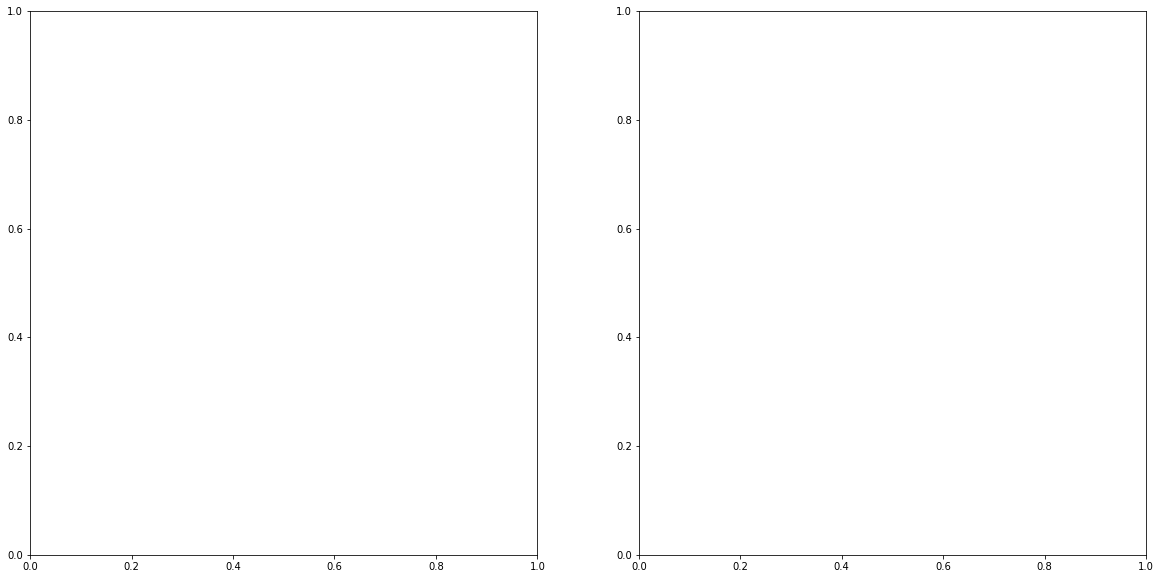

In [40]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

# Build the Model :

In [41]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)
# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)
# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

In [67]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)
#inputs = Input((768, 768, 3))

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)


outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

if NET_SCALING is not None:
    outputs = layers.UpSampling2D(NET_SCALING) (outputs)
    
model_1 = models.Model(inputs=[input_img], outputs=[outputs])
model_1.compile(optimizer='adam', loss= IoU_loss, metrics=[IoU, back_IoU])
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 256, 256, 3)  0           average_pooling2d_7[0][0]        
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 256, 256, 3)  12          gaussian_noise_4[0][0]           
__________________________________________________________________________________________________
conv2d_58 

In [68]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [69]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model_1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [70]:
def fit():
    model_1.compile(optimizer=Adam(1e-3, decay=1e-10), loss=IoU, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [model_1.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

Epoch 1/99
9/9 [==============================] - 17s 2s/step - loss: -0.0057 - binary_accuracy: 0.9625 - val_loss: -0.0064 - val_binary_accuracy: 0.8692

Epoch 00001: val_loss improved from inf to -0.00645, saving model to model_1_weights.best.hdf5
Epoch 2/99
9/9 [==============================] - 12s 1s/step - loss: -0.0140 - binary_accuracy: 0.8627 - val_loss: -0.0305 - val_binary_accuracy: 0.7734

Epoch 00002: val_loss improved from -0.00645 to -0.03048, saving model to model_1_weights.best.hdf5
Epoch 3/99
9/9 [==============================] - 13s 1s/step - loss: -0.0566 - binary_accuracy: 0.6783 - val_loss: -0.0705 - val_binary_accuracy: 0.6541

Epoch 00003: val_loss improved from -0.03048 to -0.07047, saving model to model_1_weights.best.hdf5
Epoch 4/99
9/9 [==============================] - 13s 1s/step - loss: -0.0661 - binary_accuracy: 0.6228 - val_loss: -0.0913 - val_binary_accuracy: 0.6255

Epoch 00004: val_loss improved from -0.07047 to -0.09125, saving model to model_1_wei

9/9 [==============================] - 12s 1s/step - loss: -0.2041 - binary_accuracy: 0.9755 - val_loss: -0.2225 - val_binary_accuracy: 0.9701

Epoch 00032: val_loss did not improve from -0.22535
Epoch 33/99
9/9 [==============================] - 12s 1s/step - loss: -0.2139 - binary_accuracy: 0.9737 - val_loss: -0.2224 - val_binary_accuracy: 0.9700

Epoch 00033: val_loss did not improve from -0.22535
Epoch 34/99
9/9 [==============================] - 12s 1s/step - loss: -0.1741 - binary_accuracy: 0.9733 - val_loss: -0.2225 - val_binary_accuracy: 0.9701

Epoch 00034: val_loss did not improve from -0.22535
Epoch 35/99
9/9 [==============================] - 13s 1s/step - loss: -0.1716 - binary_accuracy: 0.9766 - val_loss: -0.2226 - val_binary_accuracy: 0.9702

Epoch 00035: val_loss did not improve from -0.22535
Epoch 36/99
9/9 [==============================] - 13s 1s/step - loss: -0.1951 - binary_accuracy: 0.9766 - val_loss: -0.2227 - val_binary_accuracy: 0.9703

Epoch 00036: val_loss di

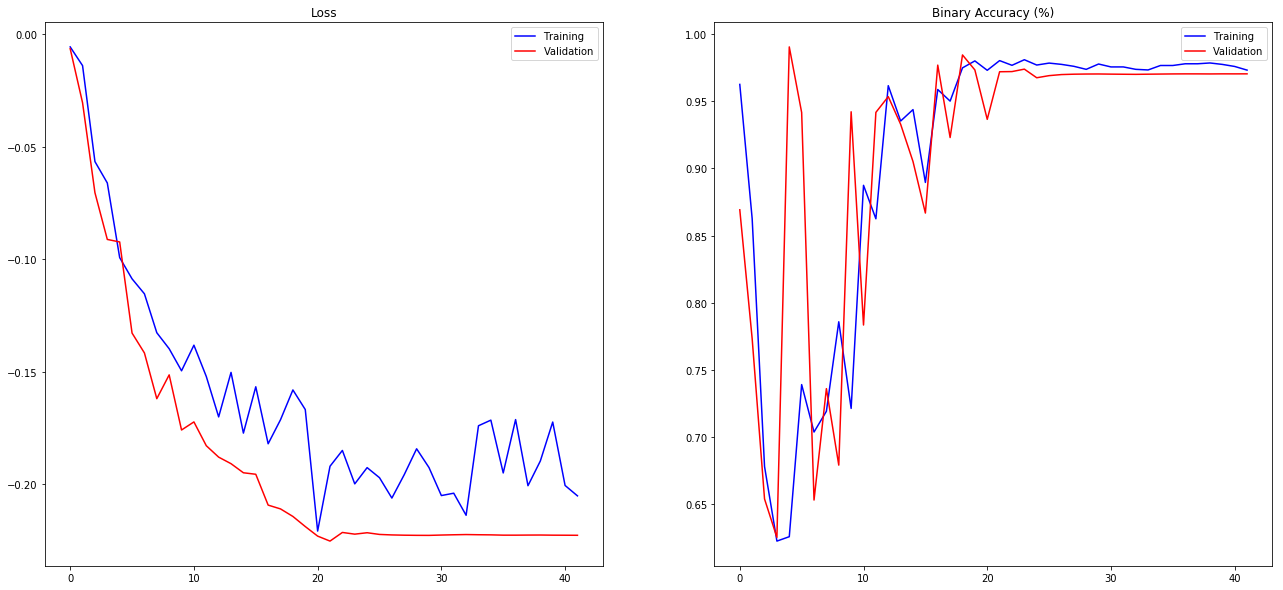

In [71]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [72]:
model_1.load_weights(weight_path)
model_1.save('seg_model.h5')

In [73]:
pred_y = model_1.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 1.31143e-05 0.669948 0.0296098


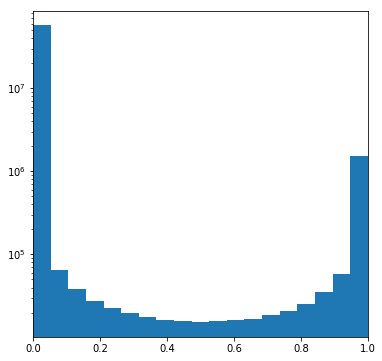

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

## Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [75]:

if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(model_1)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = model_1
fullres_model.save('fullres_model_1.h5')

ValueError: Variable batch_normalization_4/moving_mean/biased already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "D:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()
  File "D:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)


# Visualisation of predictions

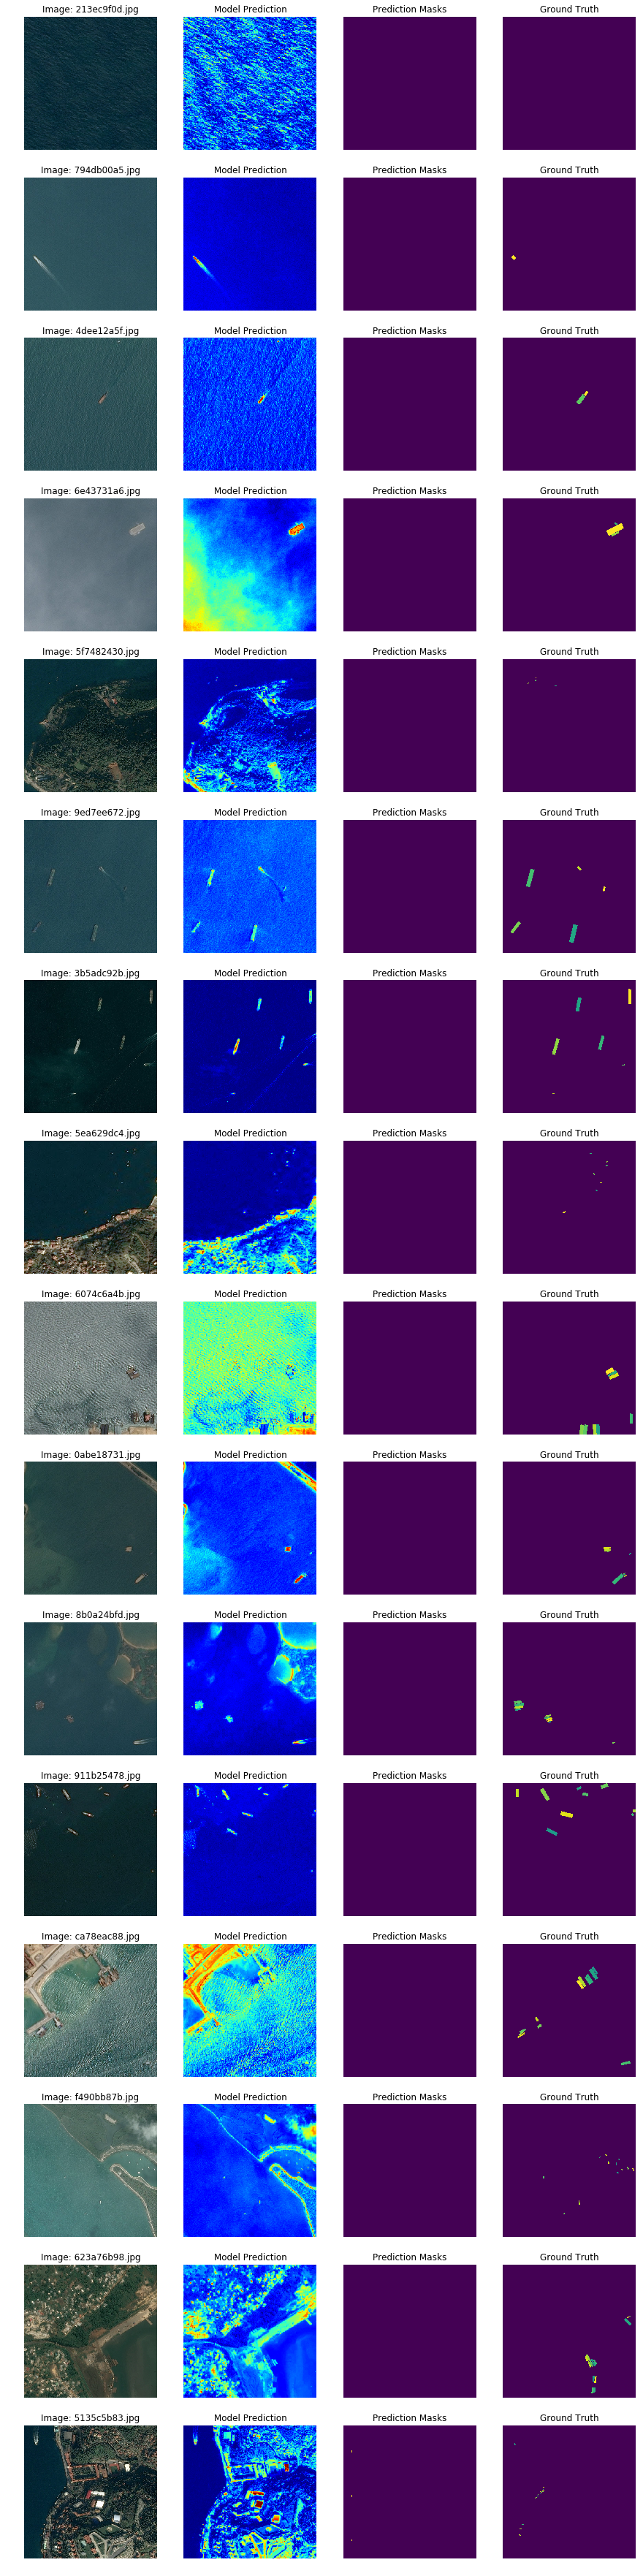

In [76]:
from matplotlib.cm import get_cmap
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')